In [7]:
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

In [3]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))
head(cleveland_data) 

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [4]:
# cleaning, wrangling data
cleveland_data[ cleveland_data == "?" ] <- NA

cleveland_tidy <- cleveland_data |>
                    mutate(diag = ifelse(is.na(num), NA, (num > 0))) |>
                    mutate(sex = as.factor(sex), cp = as.factor(cp), 
                           fbs = as.factor(fbs), restecg = as.factor(restecg),
                           exang = as.factor(exang), thal = as.factor(thal),
                           ca = as.factor(ca), slope = as.factor(slope))

#splitting data into training sets 
cleveland_split <- initial_split(cleveland_tidy, prop = 3/4, strata = num)

cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)
head(cleveland_train)
head(cleveland_test)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<lgl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,FALSE
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,FALSE
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0,FALSE
56,0,2,140,294,0,2,153,0,1.3,2,0.0,3.0,0,FALSE
57,1,3,150,168,0,0,174,0,1.6,1,0.0,3.0,0,FALSE
54,1,4,140,239,0,0,160,0,1.2,1,0.0,3.0,0,FALSE


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<lgl>
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,FALSE
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,FALSE
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,0,FALSE
44,1,2,120,263,0,0,173,0,0.0,1,0.0,7.0,0,FALSE
52,1,3,172,199,1,0,162,0,0.5,1,0.0,7.0,0,FALSE
48,0,3,130,275,0,0,139,0,0.2,1,0.0,3.0,0,FALSE


In [6]:
cleveland_summary <- cleveland_train |>
                    group_by(diag) |>
                    summarize(min_age = min(age), max_age = max(age), mean_age = mean(age),
                              min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol), 
                              min_thalach = min(thalach), max_thalach = max(thalach), mean_thalach = mean(thalach),
                              n_of_patients = n())

cleveland_summary

diag,min_age,max_age,mean_age,min_chol,max_chol,mean_chol,min_thalach,max_thalach,mean_thalach,n_of_patients
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,29,74,52.68033,126,564,243.0492,96,202,159.6148,122
TRUE,35,77,56.64423,131,409,251.0962,71,177,140.5288,104


`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'chol'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'trestbps'. You can override using the
`.groups` argument.
Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


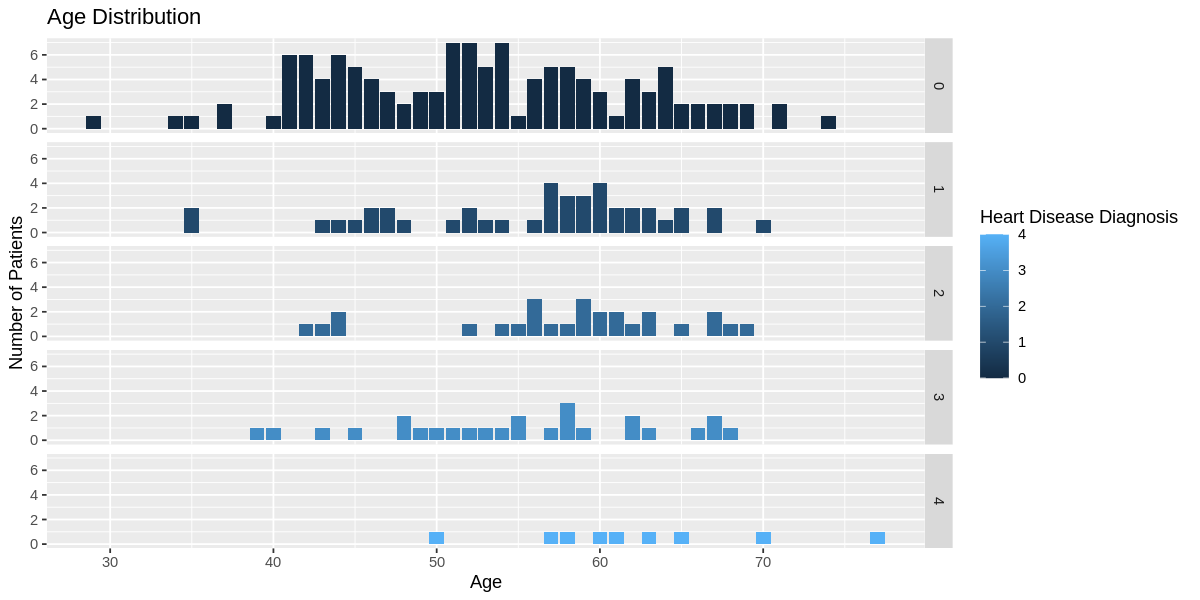

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


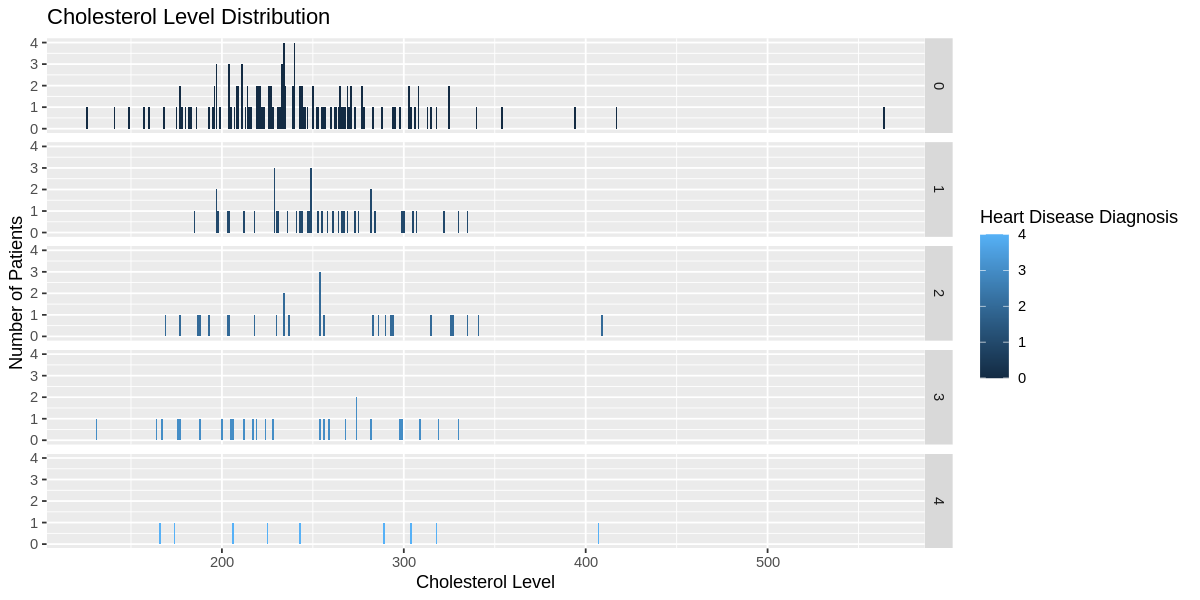

ERROR: Error in plot_grid(age_vs_count_plot, chol_vs_count_plot, trestbps_vs_count_plot): could not find function "plot_grid"


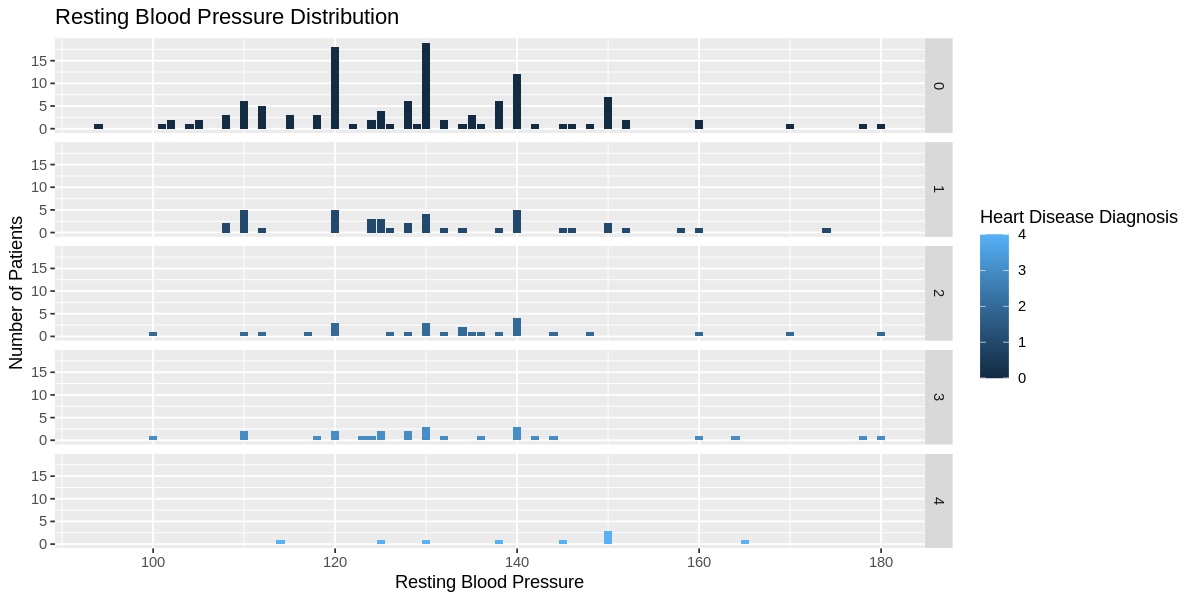

In [17]:
#get rid of the unknown data
tidier_data <- cleveland_train |> 
    filter(chol != "?" & trestbps != "?") |> 
    mutate(chol = as.numeric(chol) , trestbps = as.numeric(trestbps))

age_data <- tidier_data |>
    group_by(age, num) |>
    summarize(count = n()) |>
    ungroup()

chol_data <- tidier_data |>
    group_by(chol, num) |>
    summarize(count = n()) |>
    ungroup()

trestbps_data <- tidier_data |>
    group_by(trestbps, num) |>
    summarize(count = n()) |>
    ungroup()

options(repr.plot.width = 10, repr.plot.height = 5)

age_vs_count_plot <- age_data |>
    ggplot(aes(x = age, y = count, fill = num)) +
    geom_histogram(stat = "identity") +
    facet_grid(vars(num)) +
    labs(x = "Age", y = "Number of Patients", fill = "Heart Disease Diagnosis") +
    ggtitle("Age Distribution")
age_vs_count_plot
# age_vs_count_plot

chol_vs_count_plot <- chol_data |>
    ggplot(aes(x = chol, y = count, fill = num)) +
    geom_histogram(stat = "identity") +
    facet_grid(vars(num)) +
    labs(x = "Cholesterol Level", y = "Number of Patients", fill = "Heart Disease Diagnosis") +
    ggtitle("Cholesterol Level Distribution")
chol_vs_count_plot
# chol_vs_count_plot

trestbps_vs_count_plot <- trestbps_data |>
    ggplot(aes(x = trestbps, y = count, fill = num)) +
    geom_histogram(stat = "identity") +
    facet_grid(vars(num)) +
    labs(x = "Resting Blood Pressure", y = "Number of Patients", fill = "Heart Disease Diagnosis") +
    ggtitle("Resting Blood Pressure Distribution")
trestbps_vs_count_plot
